## 1. Descriptive Analysis - Dataset Preparation ##

### 1a. videoTitles - translated video titels to identify "hunting" videos ###

In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from collections import Counter

path = 'desc_title_translated.pkl'
# Open the file for reading in binary mode
with open(path, 'rb') as file:
    # Load the object from the file
    translated = pickle.load(file)

# Display the data
# translated.head(5)

In [2]:
import pandas as pd
import re

# Custom function to check for "hunt" variations
def contains_hunt(title):
    pattern = re.compile(r'\bhunt(?:s|ing|ed)?\b')
    return bool(pattern.search(title.lower()))

# Create a new column "hunt" with True/False values based on the presence of "hunt" variations in the titles
translated['hunt'] = translated['title_en'].apply(contains_hunt)

#translated.head()

In [3]:
# Count the number of occurrences of "hunt" in the "hunt" column
num_hunt_videos = sum(translated['hunt'] == True)
num_no_hunt_videos = sum(translated['hunt'] == False)

# Print the result
print(f"The number of video titles containing variations of the word 'hunt' is: {num_hunt_videos}")
print(f"The number of video titles NOT containing variations of the word 'hunt' is: {num_no_hunt_videos}")

The number of video titles containing variations of the word 'hunt' is: 334
The number of video titles NOT containing variations of the word 'hunt' is: 3561


In [4]:
hunt_videos = translated[['yt8M_id','title_en','hunt']]

### 1b. videoDets - video details, such as engagement metrics, categories, duration, etc. ###

In [5]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt

path = 'videoDets.pkl'
# Open the file for reading in binary mode
with open(path, 'rb') as file:
    # Load the object from the file
    dets = pickle.load(file)

# Display the data
#dets.head()

In [6]:
dets = dets[['yt8M_id', 'snippet.title',
             'snippet.categoryId', 'snippet.publishedAt',
             'contentDetails.duration','status.madeForKids',
             'statistics.viewCount', 'statistics.likeCount', 
             'statistics.favoriteCount', 'statistics.commentCount',
            ]]
#dets.head()

In [7]:
# merge hunt_videos and dets
# Join the DataFrames on the 'yt8M_id' column
dets_hunt = dets.merge(hunt_videos, on='yt8M_id')
#dets_hunt.head(3)

### 1c. videoTitles + videoDets - merged dataset for descriptive analysis ###

In [8]:
columns4 = ['statistics.viewCount', 'statistics.likeCount', 'statistics.favoriteCount', 'statistics.commentCount']
for column in columns4:
    dets_hunt[column] = pd.to_numeric(dets_hunt[column], errors='coerce')

In [9]:
import pandas as pd

# create the dictionary mapping category IDs to category names
category_dict = {'15': 'Pets & Animals', '19': 'Travel & Events', '17': 'Sports',
                 '22': 'People & Blogs', '24': 'Entertainment', '27': 'Education',
                 '29': 'Nonprofits & Activism', '1': 'Film & Animation',
                 '28': 'Science & Technology', '25': 'News & Politics', '10': 'Music',
                 '26': 'Howto & Style', '2': 'Autos & Vehicles', '23': 'Comedy', '20': 'Gaming'}

# use the map() function to replace category IDs with category names
dets_hunt['snippet.categoryId'] = dets_hunt['snippet.categoryId'].map(category_dict)

In [10]:
import pandas as pd
import isodate

# convert the duration strings to seconds
dets_hunt['contentDetails.duration'] = dets_hunt['contentDetails.duration'].apply(lambda x: isodate.parse_duration(x).total_seconds())

# convert snippet.publishedAt datetime strings to YYYY-MM-DD format
dets_hunt['snippet.publishedOn'] = pd.to_datetime(dets_hunt['snippet.publishedAt']).dt.strftime('%Y-%m-%d')

# display the updated dataframe
dets_hunt = dets_hunt[['yt8M_id', 'snippet.title', 'title_en', 'snippet.publishedAt', 'snippet.publishedOn','contentDetails.duration',
                       'snippet.categoryId', 'status.madeForKids',
                       'statistics.viewCount','statistics.likeCount','statistics.favoriteCount','statistics.commentCount','hunt']]

### 1d. Explanation of the columns ###
- 'yt8M_id': The YouTube-8M ID of the video.
- 'snippet.title': The title of the video.
- 'title_en': The title of the video - translated to English.
- 'snippet.publishedAt': The date and time when the video was published.
- 'snippet.publishedOn': The date when the video was published.
- 'contentDetails.duration': The length of the video.
- 'snippet.categoryId': The ID of the category that the video belongs to.
- 'status.madeForKids': Indicates whether the video is made for kids (True/False).
- 'statistics.viewCount': The number of views the video has received.
- 'statistics.likeCount': The number of likes the video has received.
- 'statistics.favoriteCount': The number of times the video has been added to a user's favorites.
- 'statistics.commentCount': The number of comments on the video.
- 'hunt': Indicates whether the video titles includes the word 'hunt*' (True/False).

In [11]:
# Sample Columns
dets_hunt.head(2)

,yt8M_id,snippet.title,title_en,snippet.publishedAt,snippet.publishedOn,contentDetails.duration,snippet.categoryId,status.madeForKids,statistics.viewCount,statistics.likeCount,statistics.favoriteCount,statistics.commentCount,hunt
0,HTft,Obserwator 22: Jesień na tamie / Autumn on a ...,Observer 22: Autumn on a Beaver's Dam,2014-11-05T07:49:51Z,2014-11-05,483.0,Pets & Animals,False,2415,19.0,0,3.0,False
1,VX3C,bébés ocelots et otocyons au Domaine des Fauves,Babies and Otocyons in the Domaine des Fauves,2011-11-01T06:43:23Z,2011-11-01,214.0,Pets & Animals,False,5582,27.0,0,1.0,False


## 2. Descriptive Analysis - Results ##

### 2a. Engagement Metrics ###

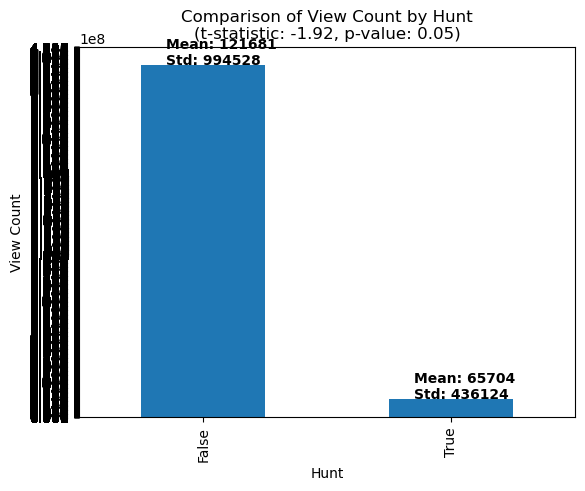

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind_from_stats

# group the viewCount data by the hunt column and calculate the sum, while accounting for NaN values
viewcount_by_hunt = dets_hunt.groupby('hunt')['statistics.viewCount'].agg(lambda x: x.sum(skipna=True))

# calculate the mean and standard deviation of the view count data for each hunt category
mean_viewcount_by_hunt = dets_hunt.groupby('hunt')['statistics.viewCount'].mean()
std_viewcount_by_hunt = dets_hunt.groupby('hunt')['statistics.viewCount'].std()

# calculate the sample sizes for each hunt category
n_true = dets_hunt['hunt'].dropna().value_counts()[True]
n_false = dets_hunt['hunt'].dropna().value_counts()[False]

# run Welch's t-test on the view count data, stratified by the hunt column
t_statistic, p_value = ttest_ind_from_stats(mean1=mean_viewcount_by_hunt[True], std1=std_viewcount_by_hunt[True], nobs1=n_true,
                                            mean2=mean_viewcount_by_hunt[False], std2=std_viewcount_by_hunt[False], nobs2=n_false,
                                            equal_var=False)

# plot the results
ax = viewcount_by_hunt.plot(kind='bar')
ax.set_xlabel('Hunt')
ax.set_ylabel('View Count')
ax.set_title('Comparison of View Count by Hunt\n(t-statistic: {:.2f}, p-value: {:.2f})'.format(t_statistic, p_value))

# adjust the y-axis to show at 20,000 increments
ax.set_ylim([0, round(ax.get_ylim()[1] / 20000) * 20000])
ax.yaxis.set_ticks(np.arange(0, ax.get_ylim()[1] + 1, 20000))

# add mean and standard deviation values for each bar to the plot
for i, v in enumerate(viewcount_by_hunt):
    ax.text(i - 0.15, v + 20000, 'Mean: {:.0f}\nStd: {:.0f}'.format(mean_viewcount_by_hunt[i], std_viewcount_by_hunt[i]), fontweight='bold')

# show the plot
plt.show()

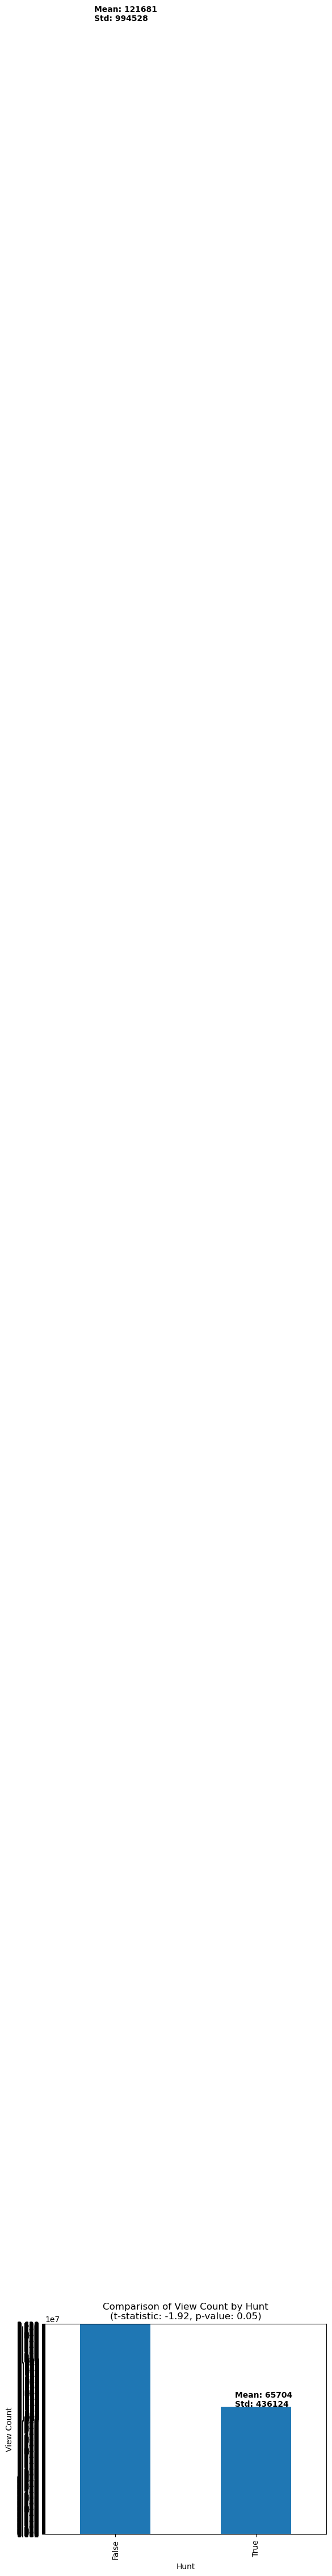

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind_from_stats

# group the viewCount data by the hunt column and calculate the sum, while accounting for NaN values
viewcount_by_hunt = dets_hunt.groupby('hunt')['statistics.viewCount'].agg(lambda x: x.sum(skipna=True))

# calculate the mean and standard deviation of the view count data for each hunt category
mean_viewcount_by_hunt = dets_hunt.groupby('hunt')['statistics.viewCount'].mean()
std_viewcount_by_hunt = dets_hunt.groupby('hunt')['statistics.viewCount'].std()

# calculate the sample sizes for each hunt category
n_true = dets_hunt['hunt'].dropna().value_counts()[True]
n_false = dets_hunt['hunt'].dropna().value_counts()[False]

# run Welch's t-test on the view count data, stratified by the hunt column
t_statistic, p_value = ttest_ind_from_stats(mean1=mean_viewcount_by_hunt[True], std1=std_viewcount_by_hunt[True], nobs1=n_true,
                                            mean2=mean_viewcount_by_hunt[False], std2=std_viewcount_by_hunt[False], nobs2=n_false,
                                            equal_var=False)

# plot the results
ax = viewcount_by_hunt.plot(kind='bar')
ax.set_xlabel('Hunt')
ax.set_ylabel('View Count')
ax.set_title('Comparison of View Count by Hunt\n(t-statistic: {:.2f}, p-value: {:.2f})'.format(t_statistic, p_value))

# manually set the y-axis limit to a value closer to the maximum view count
max_viewcount = dets_hunt['statistics.viewCount'].max()
ax.set_ylim([0, round(max_viewcount / 100000) * 100000])
ax.yaxis.set_ticks(np.arange(0, ax.get_ylim()[1] + 1, 20000))

# add mean and standard deviation values for each bar to the plot
for i, v in enumerate(viewcount_by_hunt):
    ax.text(i - 0.15, v + 20000, 'Mean: {:.0f}\nStd: {:.0f}'.format(mean_viewcount_by_hunt[i], std_viewcount_by_hunt[i]), fontweight='bold')

# show the plot
plt.show()


### 2b. Engagement Metrics - Correlation ###

### 2c. Content Categories ###

### 2d. Content Duration ###

### 2e. Published Dates ###

### 2f. Other Words in the Video Titles ###

In [ ]:
#Py file: "C:\Users\yujin\OneDrive\Documents\GitHub\human-wildlife-interactions\src\features\translation.py"
#notebook "C:\Users\yujin\OneDrive\Documents\GitHub\human-wildlife-interactions\notebooks\cluster_translation.ipynb"